# DE SuperTrend Meo

## Import modules

In [1]:
#!pip install yfinance
#!pip install pandas_ta
#!pip install python-binance
try:
  import pandas_ta
except ModuleNotFoundError:
  !pip install pandas_ta
  pass

try:
  import binance
except ModuleNotFoundError:
  !pip install python-binance
  pass

try:
  import pymoo
except ModuleNotFoundError:
  !pip install pymoo
  pass
#Notes
#https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d
#https://twopirllc.github.io/pandas-ta/#overlap-33

# Don't forget to activate

In [2]:
#basestuffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#timestuffs
from datetime import datetime, timedelta
import time

#financestuffs
import pandas_ta as ta
import math
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

#query
import urllib.request
import json
#from google.colab import drive #unactived for dektop version

#
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.moead import MOEAD, ParallelMOEAD
from pymoo.factory import get_reference_directions, get_visualization
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize

## Parameters

In [3]:
# ############### PARAMETERS ############################## #
#crypto name
crypto ="ETH"

# TIMESPAN
atr_period = 10
atr_multiplier = 3
p = 9 # number of times atr should be added or removed from current price to obtain Target 
q = 25 # number of times atr should be added or removed from current price to obtain StopLoss

# FREQ
#fr_bnb = '1h'
fr_bnb = '1m'
fr_ml = 'H'
lm= 1440
ln_tf = "15min" #lunarcrush timeframe
interval = Client.KLINE_INTERVAL_1MINUTE #KLINE_INTERVAL_10MINUTE
limit = 7 # collect data for 7 days


################ API Instantiation
# instantiate parser to load ini file
config = configparser.ConfigParser()
config.read('CryptoBot/credentials.ini') #Set to TESTNET

api_k = config['general']['api_k']
api_sk = config['general']['api_sk']

# TESTNET instantiate parser to load ini file
t_config = configparser.ConfigParser()
t_config.read('CryptoBot/testnet_credentials.ini') #Set to TESTNET 1, for TESTNET 2 'goku_testnet_credentials.ini' 

t_api_k = t_config['general']['api_k']
t_api_sk = t_config['general']['api_sk']

## Functions

In [4]:
def get_hklines(symbol, interval, limit=7):
    ''' Function that collects data from Binance API using historical klines'''  
    try:
        #klines = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")        
        hklines = client.get_historical_klines(symbol, interval, str(limit) + " day ago")
        df = pd.DataFrame(hklines, columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'Quote_asset_volume', 'Number_of_trades', 'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'])
    except BinanceAPIException as e:
        print(e)
        time.sleep(60*5)

    df['Datetime'] = df['Datetime'].astype('datetime64[ms]')
    df['Close_time'] = df['Close_time'].astype('datetime64[ms]')     

    df.set_index('Datetime', inplace=True)
    cols = df.columns[df.dtypes.eq('object')]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    return df 

In [5]:
def conditions(df, p=6, q=6):
    '''Function that builds up conditions variables for BUY -- and maybe later for SELL'''
    #Make a copy of DF
    _df = df.copy()
    #add supatrend
    _df['st_value'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
    _df['st_ind'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

    # EMA200, ATR and StochRSI
    _df['ema200'] = _df.ta.ema(length=200)
    _df['atr'] = _df.ta.atr()
    _df['rsi_stoch_k'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
    _df['rsi_stoch_d'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
    _df.dropna(inplace=True)

    # Some conditions
    # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat
    # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
    # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
    _df['Buy'] = np.where((_df.Close > _df.ema200) & (_df['st_ind'] == 1) & (_df['rsi_stoch_k'] < 20), 1, 0)

    #comment 
    #(_df.Close - p * _df.atr  >= _df.Low.shift(-1)), 1, 0)
    # check if the trade would have worked // check if the lower price of next period is higher than our stoploss
    # Ratio p:q
    _df['Target'] = np.where(_df['Buy'] == 1, _df.Close + p * _df.atr, 0) 
    _df['Stop'] = np.where(_df['Buy'] == 1, _df.Close - q * _df.atr, 0) 

    return _df

In [6]:
def buys_sells_df(df):
    '''Builds a Buy and Sell dataframe to check profitability''' 
    ### Buy and Sell conditions
    buys, sells = [], []
    for i in range(len(df)):
        if df.Buy.iloc[i]:
            buys.append(df.iloc[i].name)

            for j in range(len(df) - i):
                if df.Target.iloc[i] < df.Close.iloc[i + j] or \
                df.Stop.iloc[i] > df.Close.iloc[i + j]:
                    sells.append(df.iloc[i + j].name)
                    break
    frame = pd.DataFrame([buys,sells]).T.dropna()
    frame.columns = ['Buys', 'Sells']
    return frame

In [7]:
def proft(x):
    '''Modded function that computes actuals buy and sells and compute profit vector'''
    '''Profit already uses conditions so no need to call it first!'''
    '''x is a list variable [p,q] containing p and q values'''
    dfo = conditions(df, x[0], x[1])
    a = buys_sells_df(dfo)[:1].append(buys_sells_df(dfo)[buys_sells_df(dfo).Buys > buys_sells_df(dfo).Sells.shift(1)])
    profit = (dfo.loc[a.Sells].Close.values - dfo.loc[a.Buys].Close.values) / dfo.loc[a.Buys].Close.values
    return profit

In [8]:
def proft_bt(_df,x):
    '''Modded function that computes actuals buy and sells and compute profit vector'''
    '''Profit already uses conditions so no need to call it first!'''
    '''x is a list variable [p,q] containing p and q values'''
    dfo = conditions(_df, x[0], x[1])
    a = buys_sells_df(dfo)[:1].append(buys_sells_df(dfo)[buys_sells_df(dfo).Buys > buys_sells_df(dfo).Sells.shift(1)])
    profit = (dfo.loc[a.Sells].Close.values - dfo.loc[a.Buys].Close.values) / dfo.loc[a.Buys].Close.values
    return profit

In [9]:
def plot_supatrend_stoch(df, x):
    '''Function that plot SupaTrend'''
    df = conditions(df, x[0], x[1])
    actualtrades = buys_sells_df(df)[:1].append(buys_sells_df(df)[buys_sells_df(df).Buys > buys_sells_df(df).Sells.shift(1)])
    # Pick needed variables from df
    st = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)
    strsi = pd.DataFrame({'STOCHRSIk_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3'], 'STOCHRSId_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3'], "HI" : [80]*len(df.ta.stochrsi(length = 14, k=1).index), "LO" : [20]*len(df.ta.stochrsi(length = 14, k=1).index)})
    st["Close"] = df.Close
    st["ema200"] = df.ema200

    #figures
    fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,10))

    ax1.plot(st['SUPERTl_7_3.0'], color='green', label='SuperTrend LONG')
    ax1.plot(st['SUPERTs_7_3.0'], color='red', label='SuperTrend SHORT')
    ax1.plot(st['Close'], color='black', label='Price')
    ax1.plot(st[st.columns[-3:]]['ema200'], color='blue', label='ema200')
    ax1.set_title(crypto + " - " + fr_bnb)
    ax1.plot(actualtrades.Buys, df.loc[actualtrades.Buys]['Close'], '^', markersize=10, color='g')
    ax1.plot(actualtrades.Sells, df.loc[actualtrades.Sells]['Close'], '^', markersize=10, color='r')
    ax1.legend()

    ax2.plot(strsi['STOCHRSIk_14_14_1_3'], color ='red', label='stoch. RSI k')
    ax2.plot(strsi['STOCHRSId_14_14_1_3'], color='blue', label='stoch. RSI D')
    ax2.plot(strsi['HI'], color='black', linestyle="--")
    ax2.plot(strsi['LO'], color='black', linestyle="--")
    ax2.grid(True)
    ax2.legend()
    plt.show()

In [10]:
class MyProblem(ElementwiseProblem):
    '''Define class used to run the maxmin optimization'''    
    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([1,1]),
                         xu=np.array([20,20]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = - proft(x).mean()
        #f1 = - proft(x).sum()
        f2 = proft(x).std()
        out["F"] = [f1, f2]

problem = MyProblem()

## Load data

In [11]:
# Connect to Binance Client
client = Client(t_api_k, t_api_sk, testnet=True)

In [12]:
# Load historical data from Binance
df_total = get_hklines(crypto+'USDT', interval, limit)

2022-05-30 09:06:00


In [ ]:
# I will split data in 2:
cutoff_date = df_total.index.max() - pd.Timedelta(days=2)
print (cutoff_date)
## 5 Days for backtest
df = df_total[df_total.index <= cutoff_date] 
## 2 Days for validation
df_v = df_total[df_total.index > cutoff_date]

In [31]:
#df_total.index.max()# + pd.Timedelta(days=1)

Timestamp('2022-06-01 09:06:00')

## Conditions

Let's define buying and selling conditions as stated in https://www.youtube.com/watch?v=6zOMjMGM0ko&t=7s

LONG Conditions:


*   Price over ema200
*   Long signal on SuperTrend
*   Stock RSI under 20

SHORT Conditions:


*   Price under ema200
*   SHORT signal on SuperTrend
*   Stock RSI over 80

SIMPLE SPOT VERSION
* Market : CRYPTO
* Define Trend : stock above 200-day ema
* Entry : Stochastic RSI comes below 20
* Target Price : 6 * ATR Higher or Lower to the Entry Price


## Backtest Trades and Profits

### First training on 5 days data

In [13]:
# Create the reference directions to be used for the optimization
ref_dirs1 = get_reference_directions("das-dennis", 2, n_partitions=12)

# Instantiate NSGA3
algorithm = NSGA3(
    pop_size=20,
    n_offsprings=1,
    sampling=get_sampling("int_random"),
    crossover=get_crossover("int_sbx", prob=0.9, eta=15),
    mutation=get_mutation("int_pm", eta=20),
    eliminate_duplicates=True,
    ref_dirs=ref_dirs1
)
#algorithm = NSGA3(pop_size=20,
#                  ref_dirs=ref_dirs
#)
# Termination condition
termination = get_termination("n_gen", 10)

In [14]:
# execute the optimization
start_time = time.time()

res1 = minimize(problem,
               algorithm,
               seed=1,
               termination=('n_gen', 20), 
               save_history=True, 
               verbose=True
              )

print("--- %s seconds ---" % (time.time() - start_time))

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      20 |       2 |            - |            -
    2 |      21 |       2 |  0.00000E+00 |            f
    3 |      22 |       2 |  0.00000E+00 |            f
    4 |      23 |       2 |  0.00000E+00 |            f
    5 |      24 |       2 |  0.00000E+00 |            f
    6 |      25 |       2 |  0.00000E+00 |            f
    7 |      26 |       3 |  0.205584487 |            f
    8 |      27 |       4 |  0.021196910 |        ideal
    9 |      28 |       4 |  0.00000E+00 |            f
   10 |      29 |       4 |  0.00000E+00 |            f
--- 3198.7640051841736 seconds ---


In [15]:
# Run the minimize function
#res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)
#X = res.X
#F = res.F
X1 = res1.X
F1 = res1.F
print(X1)
print(F1)

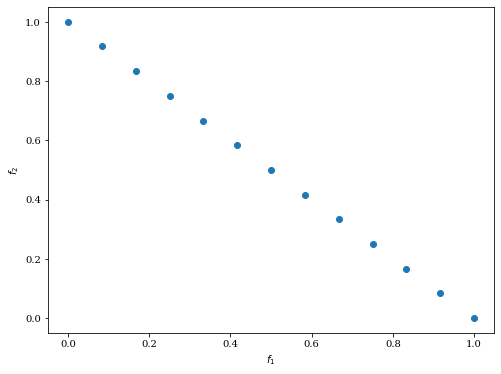

In [16]:
#
get_visualization("scatter").add(ref_dirs1).show()

In [17]:
#Plot results
xdf = pd.DataFrame(X1, columns=['p','q'])
fdf = pd.DataFrame(100* F1, columns=['Minus Mean Profit', 'StDev'])
rdf = pd.concat([xdf,fdf], axis=1)
rdf

,p,q,Minus Mean Profit,StDev
0,7,14,145.244555,27.556231
1,2,1,147.778222,10.243740
2,14,17,139.201106,31.480250
3,1,3,175.333564,9.783843


2.0

In [18]:
# Profits
# filter rdf on lines WHERE P > Q
px = rdf[rdf.p > rdf.q].iloc[0].p
qx = rdf[rdf.p > rdf.q].iloc[0].q
#
profits_bt = proft([px, qx])
win_bt = len([i for i in profits_bt if i> 0])
print('TRAINING : {} wins out of {} trades i.e. {:.2f} % winrate and a relative profit of {:.2f} % and a cumulative return of {:.2f} '.format(win_bt, len(profits_bt), 100 * win_bt/len(profits_bt), profits_bt.mean() * 100, (profits_bt + 1).cumprod()[-1]))

TRAINING : 2 wins out of 9 trades i.e. 22.22 % winrate and a relative profit of -16.14 % and a cumulative return of 0.09 


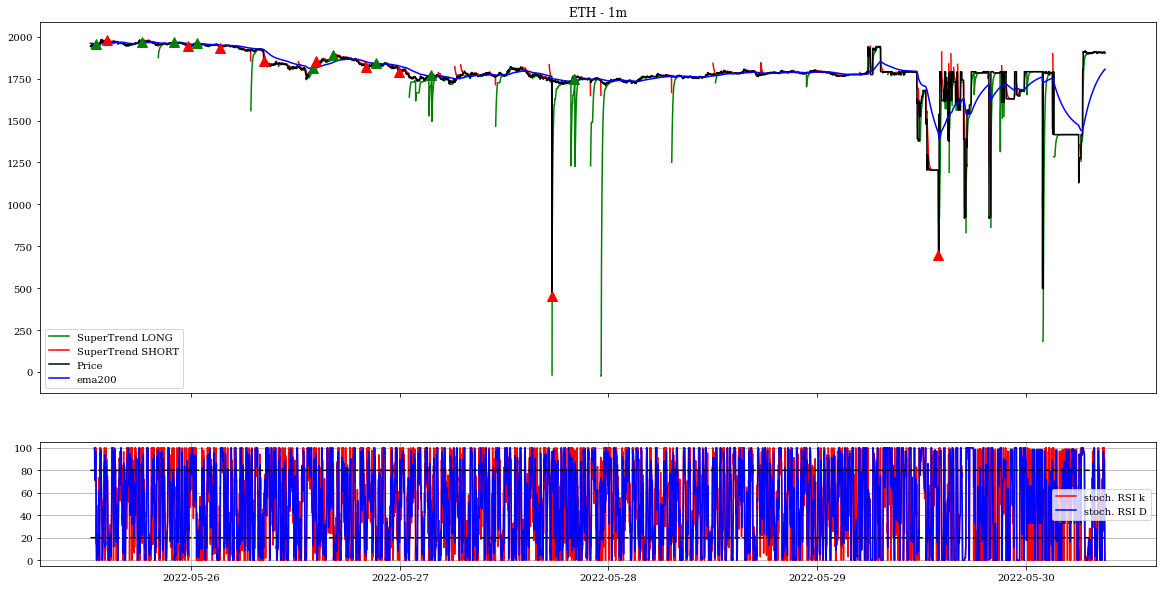

In [19]:
plot_supatrend_stoch(df, [rdf.p[0], rdf.q[0]])

### Second backtest on 2 days data

In [20]:
# Profits
profits_v = proft_bt(df_v,[px, qx])
win_v = len([i for i in profits_v if i> 0])
len_trade_v = len(profits_v)
winrate_v = 100 * win_v/len(profits_v)

print('BACKTEST : {} wins out of {} trades i.e. {:.2f} % winrate and a relative profit of {:.2f} % and a cumulative return of {:.2f} '.format(win_v, len_trade_v, winrate_v, profits_v.mean() * 100, (profits_v + 1).cumprod()[-1]))

BACKTEST : 1 wins out of 1 trades i.e. 100.00 % winrate and a relative profit of 1.49 % and a cumulative return of 1.01 


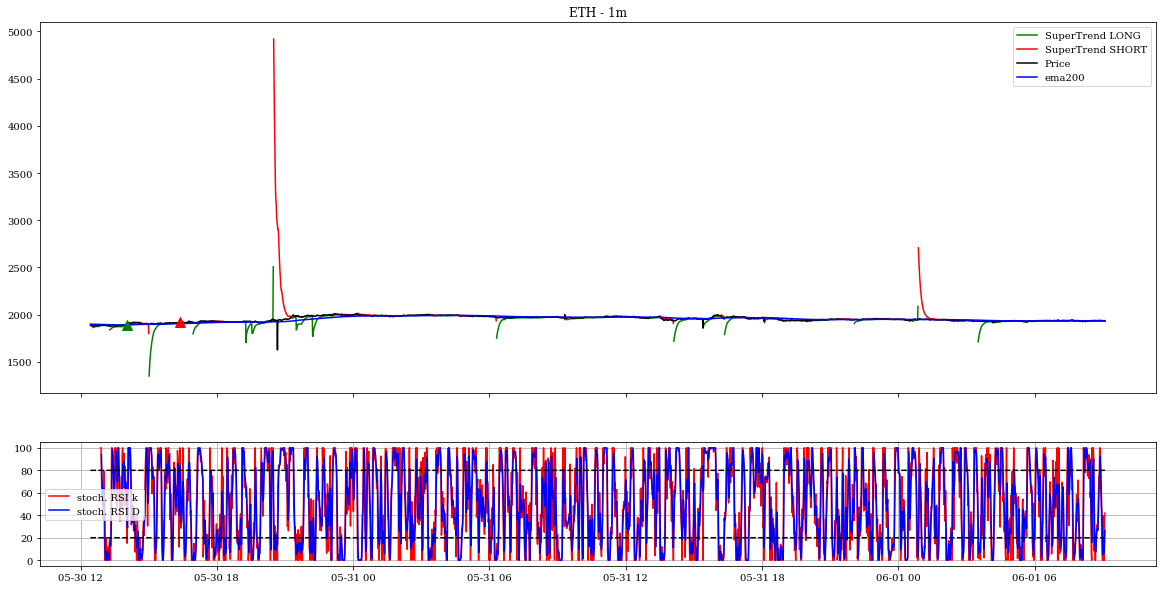

In [21]:
plot_supatrend_stoch(df_v, [rdf.p[0], rdf.q[0]])

## Build Signals and live trading on Binance Testnet